In [1]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import f1_score, precision_score, recall_score, \
    accuracy_score

import re
from typing import List, Tuple

import pandas as pd


def is_contained(inner_start, inner_end, outer_start, outer_end):
    return (
        outer_start <= inner_start <= outer_end
        and outer_start <= inner_end <= outer_end
        and (inner_start, inner_end) != (outer_start, outer_end)
    )


def find_all_occurrences_indices(
    sentence: str,
    label: str,
) -> List[Tuple[int, int]]:
    """
    Finds all occurrences of a label in a sentence and returns a list of tuples
    with the start and end indices of the occurrences.

    Args:
        sentence: The sentence to search in.
        label: The label to search for.

    Returns:
        A list of tuples with the start and end indices of the occurrences.
    """
    return [
        (int(match.start()), int(match.end()))
        for match in re.finditer(label, sentence)
    ]


def find_contained_labels(labels):
    """
    Finds all labels that are contained in other labels.

    Args:
        labels: A list of labels.

    Returns:
        A dictionary with the labels as keys and a list of labels that are
        contained in the key label as values.
    """
    return {
        label_1: [
            label2
            for label2 in labels
            if label_1 in label2 and label_1 != label2
        ]
        for label_1 in labels
    }


def find_labels_in_sentence(
    sentence: str,
    labels: List[str],
) -> List[List[Tuple[int, int]]]:
    """
    Finds all occurrences of the labels in a sentence and returns a list of
    lists with the occurrences of each label.

    Labels that are contained in other labels are not returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.

    Returns:
        A list of lists with the positional occurrence of each label.
    """
    if not labels:
        return []

    containable_map = find_contained_labels(labels)
    sentence_lower = sentence.lower()
    occurrences = [
        find_all_occurrences_indices(sentence_lower, label.lower())
        for label in labels
    ]
    label_occurrences = dict(zip(labels, occurrences))
    included_list = []
    for label, inner_pos in zip(labels, occurrences):
        contained = set()
        containing_labels = containable_map.get(label, set())

        for bigger_label in containing_labels:
            locations: List[Tuple[int, int]] = label_occurrences.get(
                bigger_label,
                list(),
            )

            for inner_start, inner_end in inner_pos:
                for outer_start, outer_end in locations:
                    if is_contained(
                        inner_start,
                        inner_end,
                        outer_start,
                        outer_end,
                    ):
                        contained.add((inner_start, inner_end))
        included_list.append(list(contained))

    return [
        list(set(pos) - set(included))
        for pos, included in zip(occurrences, included_list)
    ]


def find_label(
    sentence: str,
    labels: List[str],
    default_label: str = "?",
) -> str:
    """
    Search for given labels in the sentence and returns it if found. If only
    one label occur in the sentence, it will be returned. If no label or
    different labels occur in the sentence, '?' is returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.
        default_label: The label to return if no label or different labels
            occur in the sentence.

    Returns:
        The label that occurs in the sentence or '?' if no label occurs in the
        sentence.
    """
    occurrences = find_labels_in_sentence(sentence=sentence, labels=labels)
    non_empty_indices = [i for i, sublist in enumerate(occurrences) if sublist]
    return (
        labels[non_empty_indices[0]]
        if len(
            non_empty_indices,
        )
           == 1
        else default_label
    )


def _soft_parse(
    df: pd.DataFrame,
    in_col: str,
    parsed_col: str,
    labels: List[str] = None,
) -> pd.DataFrame:
    if labels is None:
        raise ValueError("Labels are not set!")

    df[parsed_col] = df[in_col].apply(
        lambda x: find_label(x, labels),
    )


In [2]:

# load

# load results
df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
df_flan_t5_base = pd.read_csv("./data/flan-t5-base.csv")
df_flan_t5_large = pd.read_csv("./data/flan-t5-large.csv")
df_flan_t5_xl = pd.read_csv("./data/flan-t5-xl.csv")
df_openai_gpt_3_5_turbo = pd.read_csv('./data/gpt-3.5-turbo.csv')
df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4.csv")
df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")

#load pool
pool = load_dataset('mediabiasgroup/BABE-icl-pool')['train'].to_pandas()

# exclude pool from model (if needed)
df_falcon_7b = df_falcon_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

df_flan_t5_base = df_flan_t5_base.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

df_flan_t5_large = df_flan_t5_large.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

df_flan_t5_xl = df_flan_t5_xl.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)

df_flan_ul2 = df_flan_ul2.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_7b = df_Llama_2_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_13b = df_Llama_2_13b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mistral_7b = df_mistral_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mixtral_8x7b = df_mixtral_8x7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openchat_3_5 = df_openchat_3_5.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_zephyr_7b_beta = df_zephyr_7b_beta.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)



#load babe
dataset = load_dataset('mediabiasgroup/BABE-v4')
df_babe = pd.DataFrame(dataset['train'])

# df_merge_all_runs = only contains the elements legal in all annotations
df_merge_all_runs = df_babe

# df_merge_all_runs_with_errors = only contains the elements legal in all annotations
df_merge_all_runs_with_errors = df_babe


def find_first_occurrence(string, instruction="Instruction:",
                          statement1="The answer is BIASED",
                          statement2="The answer is NOT BIASED"
                          ):
    index_instruction = string.find(instruction)
    index1 = string.find(statement1)
    index2 = string.find(statement2)

    if index1 == -1 and index2 == -1:
        return "Neither instruction nor statements found in the given string."
    elif index1 == -1 and index2 == -1:
        return "Neither statement found in the given string."
    elif index1 == -1:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"
    elif index2 == -1:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    elif index1 < index2:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    else:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"

# Falcon 7B

In [3]:
_soft_parse(df_falcon_7b, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
10,"And, of course, along the way, the hipster CEO...",'NOT BIASED'\n\nExplanation: The sentence port...,"Instruction: 'And, of course, along the way, t...","Instruction: 'And, of course, along the way, t...",?
36,"Since the incident, the mainstream media — in ...",'NOT BIASED'\n\nExplanation: The sentence is n...,"Instruction: 'Since the incident, the mainstre...","Instruction: 'Since the incident, the mainstre...",?
51,As leading 2020 Dems advocate spending big on ...,'NOT BIASED'\n\nExplanation: The sentence does...,Instruction: 'As leading 2020 Dems advocate sp...,Instruction: 'As leading 2020 Dems advocate sp...,?
211,His confidence in his sense of humor is the sa...,'NOT BIASED'\n\nExplanation: The sentence is n...,Instruction: 'His confidence in his sense of h...,Instruction: 'His confidence in his sense of h...,?
258,Father Horan was one of the many voices from t...,'NOT BIASED'\n\nExplanation: The sentence is n...,Instruction: 'Father Horan was one of the many...,Instruction: 'Father Horan was one of the many...,?
...,...,...,...,...,...
3588,Wealthy American corporations are using their ...,'NOT BIASED'\n\nExplanation: The sentence pres...,Instruction: 'Wealthy American corporations ar...,Instruction: 'Wealthy American corporations ar...,?
3618,While falling short of calling half the nation...,'NOT BIASED'\n\nExplanation: The sentence is n...,Instruction: 'While falling short of calling h...,Instruction: 'While falling short of calling h...,?
3812,Chicago Police Superintendent David Brown desc...,'NOT BIASED'\n\nExplanation: The sentence desc...,Instruction: 'Chicago Police Superintendent Da...,Instruction: 'Chicago Police Superintendent Da...,?
3872,It's not immediately clear what Biden was tryi...,'Not Biased'\n\nExplanation: The sentence is n...,Instruction: 'It's not immediately clear what ...,Instruction: 'It's not immediately clear what ...,?


In [4]:
# preprocessing
# preprocessing
def update_label(row):
    if row['response'].startswith("'BIASED'") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("'Biased'") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("1") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("'NOT BIASED'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("'Not BIASED'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("'Not Biased'") and row[
        'label'] == '?':
        return 'NOT BIASED'

    else:
        return row['label']

df_falcon_7b['label'] = df_falcon_7b.apply(update_label, axis=1)
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label


In [5]:
df_falcon_7b = df_falcon_7b.rename(columns={"label": "falcon_7b_label"})
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('BIASED', 1)
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_falcon_7b[['text', 'falcon_7b_label']], on='text')

ground_truth = df_merge['label'].astype(int)
falcon_7b_label = df_merge['falcon_7b_label'].astype(int)

In [6]:
print("F1-Score with Falcon 7b with (0 shot): ",
      f1_score(ground_truth, falcon_7b_label))
print("Precision with Falcon 7b with (0 shot): ",
      precision_score(ground_truth, falcon_7b_label))
print("Recall with Falcon 7b with (0 shot): ",
      recall_score(ground_truth, falcon_7b_label))
print("Accuracy with Falcon 7b with (0 shot): ",
      accuracy_score(ground_truth, falcon_7b_label))

F1-Score with Falcon 7b with (0 shot):  0.5398627868464633
Precision with Falcon 7b with (0 shot):  0.5102862254025045
Recall with Falcon 7b with (0 shot):  0.5730788548468106
Accuracy with Falcon 7b with (0 shot):  0.5162894802287988


# Flan T5 Base

In [7]:
_soft_parse(df_flan_t5_base, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_flan_t5_base.query("label == '?'")

,text,response,raw_data,query,label


In [8]:
df_flan_t5_base = df_flan_t5_base.rename(columns={"label": "flan_t5_base_label"})
df_flan_t5_base['flan_t5_base_label'] = df_flan_t5_base['flan_t5_base_label'].replace('BIASED', 1)
df_flan_t5_base['flan_t5_base_label'] = df_flan_t5_base['flan_t5_base_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_t5_base[df_flan_t5_base['flan_t5_base_label'] != '?'][['text', 'flan_t5_base_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_t5_base[df_flan_t5_base['flan_t5_base_label'] != '?'][['text', 'flan_t5_base_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_t5_base[['text', 'flan_t5_base_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_t5_base_label = df_merge['flan_t5_base_label'].astype(int)

In [9]:
print("F1-Score with Flan T5 base (0 shot): ", f1_score(ground_truth, flan_t5_base_label))
print("Precision with Flan T5 base (0 shot): ", precision_score(ground_truth, flan_t5_base_label))
print("Recall with Flan T5 base (0 shot): ", recall_score(ground_truth, flan_t5_base_label))
print("Accuracy with Flan T5 base (0 shot): ",  accuracy_score(ground_truth, flan_t5_base_label))

F1-Score with Flan T5 base (0 shot):  0.6531899109792285
Precision with Flan T5 base (0 shot):  0.517788885621876
Recall with Flan T5 base (0 shot):  0.8844801607232546
Accuracy with Flan T5 base (0 shot):  0.53494155682666


# Flan T5 Large

In [10]:
_soft_parse(df_flan_t5_large, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_flan_t5_large.query("label == '?'")

,text,response,raw_data,query,label


In [11]:
df_flan_t5_large = df_flan_t5_large.rename(columns={"label": "flan_t5_large_label"})
df_flan_t5_large['flan_t5_large_label'] = df_flan_t5_large['flan_t5_large_label'].replace('BIASED', 1)
df_flan_t5_large['flan_t5_large_label'] = df_flan_t5_large['flan_t5_large_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_t5_large[df_flan_t5_large['flan_t5_large_label'] != '?'][['text', 'flan_t5_large_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_t5_large[df_flan_t5_large['flan_t5_large_label'] != '?'][['text', 'flan_t5_large_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_t5_large[['text', 'flan_t5_large_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_t5_large_label = df_merge['flan_t5_large_label'].astype(int)

In [12]:
print("F1-Score with Flan T5 Large (0 shot): ", f1_score(ground_truth, flan_t5_large_label))
print("Precision with Flan T5 Large (0 shot): ", precision_score(ground_truth, flan_t5_large_label))
print("Recall with Flan T5 Large (0 shot): ", recall_score(ground_truth, flan_t5_large_label))
print("Accuracy with Flan T5 Large (0 shot): ",  accuracy_score(ground_truth, flan_t5_large_label))

F1-Score with Flan T5 Large (0 shot):  0.5924235508900045
Precision with Flan T5 Large (0 shot):  0.5428690924299456
Recall with Flan T5 Large (0 shot):  0.6519337016574586
Accuracy with Flan T5 Large (0 shot):  0.5558318826162646


# Flan T5 XL

In [13]:
_soft_parse(df_flan_t5_xl, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_flan_t5_xl.query("label == '?'")

,text,response,raw_data,query,label


In [14]:
df_flan_t5_xl = df_flan_t5_xl.rename(columns={"label": "flan_t5_xl_label"})
df_flan_t5_xl['flan_t5_xl_label'] = df_flan_t5_xl['flan_t5_xl_label'].replace('BIASED', 1)
df_flan_t5_xl['flan_t5_xl_label'] = df_flan_t5_xl['flan_t5_xl_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_t5_xl[df_flan_t5_xl['flan_t5_xl_label'] != '?'][['text', 'flan_t5_xl_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_t5_xl[df_flan_t5_xl['flan_t5_xl_label'] != '?'][['text', 'flan_t5_xl_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_t5_xl[['text', 'flan_t5_xl_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_t5_xl_label = df_merge['flan_t5_xl_label'].astype(int)


In [15]:
print("F1-Score with Flan T5 xl (0 shot): ", f1_score(ground_truth, flan_t5_xl_label))
print("Precision with Flan T5 xl (0 shot): ", precision_score(ground_truth, flan_t5_xl_label))
print("Recall with Flan T5 xl (0 shot): ", recall_score(ground_truth, flan_t5_xl_label))
print("Accuracy with Flan T5 xl (0 shot): ",  accuracy_score(ground_truth, flan_t5_xl_label))

F1-Score with Flan T5 xl (0 shot):  0.6723749436683191
Precision with Flan T5 xl (0 shot):  0.6097261953412342
Recall with Flan T5 xl (0 shot):  0.7493721747865394
Accuracy with Flan T5 xl (0 shot):  0.6383984083561303


# Flan UL2

In [16]:
_soft_parse(df_flan_ul2, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_flan_ul2.query("label == '?'")

,text,response,raw_data,query,label


In [17]:
df_flan_ul2 = df_flan_ul2.rename(columns={"label": "flan_ul2_label"})
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('BIASED', 1)
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_ul2[['text', 'flan_ul2_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_ul2_label = df_merge['flan_ul2_label'].astype(int)

In [18]:
print("F1-Score with Flan UL2 (0 shot): ", f1_score(ground_truth, flan_ul2_label))
print("Precision with Flan UL2 (0 shot): ", precision_score(ground_truth, flan_ul2_label))
print("Recall with Flan UL2 (0 shot): ", recall_score(ground_truth, flan_ul2_label))
print("Accuracy with Flan UL2 (0 shot): ",  accuracy_score(ground_truth, flan_ul2_label))

F1-Score with Flan UL2 (0 shot):  0.7186726102030709
Precision with Flan UL2 (0 shot):  0.7088422081094284
Recall with Flan UL2 (0 shot):  0.7287795077850326
Accuracy with Flan UL2 (0 shot):  0.7174832131310619


# GPT-3.5-turbo

In [19]:
_soft_parse(df_openai_gpt_3_5_turbo, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label


In [20]:
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.rename(columns={"label": "gpt_3_5_label"})
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'BIASED', 1)
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_3_5_turbo[['text', 'gpt_3_5_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_3_5_label = df_merge['gpt_3_5_label'].astype(int)

In [21]:
print("F1-Score with GPT 3.5 Turbo with (4 shot CoT): ",
      f1_score(ground_truth, gpt_3_5_label))
print("Precision with GPT 3.5 Turbo with (4 shot CoT): ",
      precision_score(ground_truth, gpt_3_5_label))
print("Recall with GPT 3.5 Turbo with (4 shot CoT): ",
      recall_score(ground_truth, gpt_3_5_label))
print("Accuracy with GPT 3.5 Turbo with (4 shot CoT): ",
      accuracy_score(ground_truth, gpt_3_5_label))

F1-Score with GPT 3.5 Turbo with (4 shot CoT):  0.7360578969774372
Precision with GPT 3.5 Turbo with (4 shot CoT):  0.6387144440339859
Recall with GPT 3.5 Turbo with (4 shot CoT):  0.8684078352586639
Accuracy with GPT 3.5 Turbo with (4 shot CoT):  0.6916190002486944


# GPT 4 turbo

In [22]:
df_openai_gpt_4_turbo.query("label == '?'")

,text,label,raw_data,query


In [23]:
df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.rename(columns={"label": "gpt_4_label"})
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'BIASED', 1)
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_4_turbo[['text', 'gpt_4_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_4_label = df_merge['gpt_4_label'].astype(int)

In [24]:
print("F1-Score with GPT 4 turbo with (0 shot): ",
      f1_score(ground_truth, gpt_4_label))
print("Precision with GPT 4 turbo with (0 shot): ",
      precision_score(ground_truth, gpt_4_label))
print("Recall with GPT 4 turbo with (0 shot ): ",
      recall_score(ground_truth, gpt_4_label))
print("Accuracy with GPT 4 turbo with (0 shot): ",
      accuracy_score(ground_truth, gpt_4_label))

F1-Score with GPT 4 turbo with (0 shot):  0.7739199575934269
Precision with GPT 4 turbo with (0 shot):  0.819304152637486
Recall with GPT 4 turbo with (0 shot ):  0.7332998493219488
Accuracy with GPT 4 turbo with (0 shot):  0.7878637154936583


# Llama-2-7b-chat-hf

In [25]:
_soft_parse(df_Llama_2_7b, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label
11,"On Monday, the Supreme Court voted in an 8-1 d...",NOT BIASED\n\nExplanation:\nThe sentence does ...,"Instruction: 'On Monday, the Supreme Court vot...","Instruction: 'On Monday, the Supreme Court vot...",?
15,Facebook bans white nationalism from platform ...,NOT BIASED\n\nExplanation: The sentence simply...,Instruction: 'Facebook bans white nationalism ...,Instruction: 'Facebook bans white nationalism ...,?
25,Trump acknowledged there might be a resurgence...,NOT BIASED\n\nExplanation: The sentence simply...,Instruction: 'Trump acknowledged there might b...,Instruction: 'Trump acknowledged there might b...,?
44,"Since taking office in 2017, Trump has worked ...",NOT BIASED\n\nExplanation: The sentence simply...,"Instruction: 'Since taking office in 2017, Tru...","Instruction: 'Since taking office in 2017, Tru...",?
50,"In a tweet, which he quickly deleted, the pres...",NOT BIASED\n\nExplanation: The sentence does n...,"Instruction: 'In a tweet, which he quickly del...","Instruction: 'In a tweet, which he quickly del...",?
...,...,...,...,...,...
4075,"But as many reminded the President, his horrif...",NOT BIASED\n\nExplanation: The sentence simply...,Instruction: 'But as many reminded the Preside...,Instruction: 'But as many reminded the Preside...,?
4084,"Posting on Twitter, the former stripper turned...",NOT BIASED\n\nExplanation: The sentence does n...,"Instruction: 'Posting on Twitter, the former s...","Instruction: 'Posting on Twitter, the former s...",?
4093,Military ships and aircraft have been deployed...,NOT BIASED\n\nExplanation:\nThe sentence provi...,Instruction: 'Military ships and aircraft have...,Instruction: 'Military ships and aircraft have...,?
4109,"In her Instagram story, Jedrzejczyk posted an ...",NOT BIASED\n\nExplanation: The sentence is not...,"Instruction: 'In her Instagram story, Jedrzejc...","Instruction: 'In her Instagram story, Jedrzejc...",?


In [26]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_Llama_2_7b['label'] = df_Llama_2_7b.apply(update_label, axis=1)
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label


In [27]:
df_Llama_2_7b = df_Llama_2_7b.rename(columns={"label": "llama_7b_label"})
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('BIASED', 1)
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_7b[['text', 'llama_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_7b_label = df_merge['llama_7b_label'].astype(int)

In [28]:
print("F1-Score with llama 7b (0 shot): ", f1_score(ground_truth, llama_7b_label))
print("Precision with llama 7b (0 shot): ", precision_score(ground_truth, llama_7b_label))
print("Recall with llama 7b (0 shot): ", recall_score(ground_truth, llama_7b_label))
print("Accuracy with llama 7b (0 shot): ",  accuracy_score(ground_truth, llama_7b_label))

F1-Score with llama 7b (2 shot):  0.6008412663272084
Precision with llama 7b (2 shot):  0.5372129849564529
Recall with llama 7b (2 shot):  0.6815670517327976
Accuracy with llama 7b (2 shot):  0.5516040785874161


# Llama-2-13b-chat-hf

In [29]:
_soft_parse(df_Llama_2_13b, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label
20,A Joe Biden presidency could reset ties with t...,NOT BIASED.\n\nReason: The sentence provides f...,Instruction: 'A Joe Biden presidency could res...,Instruction: 'A Joe Biden presidency could res...,?
31,Nobel laureate Paul Krugman breaks down Trump'...,NOT BIASED\n\nReason: The sentence simply repo...,Instruction: 'Nobel laureate Paul Krugman brea...,Instruction: 'Nobel laureate Paul Krugman brea...,?
62,"The leader of India, Prime Minister Narendra M...",NOT BIASED\n\nExplanation: The sentence provid...,"Instruction: 'The leader of India, Prime Minis...","Instruction: 'The leader of India, Prime Minis...",?
74,"Earlier in the month, Alphabet Inc's GOOGL.O G...",NOT BIASED\n\nRationale: The sentence is not b...,"Instruction: 'Earlier in the month, Alphabet I...","Instruction: 'Earlier in the month, Alphabet I...",?
77,Despite Democrats regularly characterizing Ame...,NOT BIASED\n\nExplanation: The sentence is NOT...,Instruction: 'Despite Democrats regularly char...,Instruction: 'Despite Democrats regularly char...,?
...,...,...,...,...,...
4013,"Trump, of course, is his most stunning when he...",NOT BIASED\n\nExplanation: The sentence is NOT...,"Instruction: 'Trump, of course, is his most st...","Instruction: 'Trump, of course, is his most st...",?
4019,If your “rights” mean taking everyone else’s r...,NOT BIASED\n\nReason: The sentence is expressi...,Instruction: 'If your “rights” mean taking eve...,Instruction: 'If your “rights” mean taking eve...,?
4028,"A cop shoots a Black man, and a police union f...",NOT BIASED\n\nReason: The sentence simply repo...,"Instruction: 'A cop shoots a Black man, and a ...","Instruction: 'A cop shoots a Black man, and a ...",?
4030,President Donald Trump campaigned in the battl...,NOT BIASED\n\nExplanation: The sentence is fac...,Instruction: 'President Donald Trump campaigne...,Instruction: 'President Donald Trump campaigne...,?


In [30]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_Llama_2_13b['label'] = df_Llama_2_13b.apply(update_label, axis=1)
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label


In [31]:
df_Llama_2_13b = df_Llama_2_13b.rename(columns={"label": "llama_13b_label"})
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('BIASED', 1)
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_13b[['text', 'llama_13b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_13b_label = df_merge['llama_13b_label'].astype(int)

In [32]:
print("F1-Score with Llama 2 13b with (0 shot): ",f1_score(ground_truth, llama_13b_label))
print("Precision with Llama 2 13b with (0 shot): ",precision_score(ground_truth, llama_13b_label))
print("Recall with Llama 2 13b with (0 shot): ",recall_score(ground_truth, llama_13b_label))
print("Accuracy with Llama 2 13b with (0 shot): ", accuracy_score(ground_truth, llama_13b_label))

F1-Score with Llama 2 13b with (0 shot):  0.6028280823616968
Precision with Llama 2 13b with (0 shot):  0.5955882352941176
Recall with Llama 2 13b with (0 shot):  0.6102461074836766
Accuracy with Llama 2 13b with (0 shot):  0.6018403382243223


# Mistral-7B-Instruct-v0.1

In [33]:
_soft_parse(df_mistral_7b, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label
1072,The photograph of Katie Bouman sitting in fron...,BIASSED,Instruction: 'The photograph of Katie Bouman s...,Instruction: 'The photograph of Katie Bouman s...,?
2156,Girls and women do not have the same access to...,BIAS,Instruction: 'Girls and women do not have the ...,Instruction: 'Girls and women do not have the ...,?
3156,But rather than appreciate the fact that Asian...,BIASSED,Instruction: 'But rather than appreciate the f...,Instruction: 'But rather than appreciate the f...,?


In [34]:
# preprocessing
df_mistral_7b.loc[[1072, 2156, 3156], 'label'] = 'BIASED'

In [35]:

df_mistral_7b = df_mistral_7b.rename(columns={"label": "mistral_7b_label"})
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('BIASED', 1)
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mistral_7b[['text', 'mistral_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mistral_7b_label = df_merge['mistral_7b_label'].astype(int)

In [36]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with (0 shot): ",
      f1_score(ground_truth, df_mistral_7b_label))
print("Precision with Mistral-7B-Instruct-v0.1 with (0 shot): ",
      precision_score(ground_truth, df_mistral_7b_label))
print("Recall with Mistral-7B-Instruct-v0.1 with (0 shot): ",
      recall_score(ground_truth, df_mistral_7b_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with (0 shot): ",
      accuracy_score(ground_truth, df_mistral_7b_label))

F1-Score with Mistral-7B-Instruct-v0.1 with (0 shot):  0.691905459108973
Precision with Mistral-7B-Instruct-v0.1 with (0 shot):  0.592831541218638
Recall with Mistral-7B-Instruct-v0.1 with (0 shot):  0.8307383224510296
Accuracy with Mistral-7B-Instruct-v0.1 with (0 shot):  0.6336732156180055


# Mixtral-8x7B

In [37]:
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
92,Biden’s statement was in keeping with that pra...,BIAS cannot be determined from the given sente...,Instruction: 'Biden’s statement was in keeping...,Instruction: 'Biden’s statement was in keeping...,?
120,In one of his his most recent lies President D...,BIAS_TYPE: Loaded Language\n\nEXPLANATION: The...,Instruction: 'In one of his his most recent li...,Instruction: 'In one of his his most recent li...,?
128,A federal judge on Monday overturned the Trump...,NOT BIASED\n\nExplanation:\n\nThe sentence is ...,Instruction: 'A federal judge on Monday overtu...,Instruction: 'A federal judge on Monday overtu...,?
167,U.S. President Donald Trump’s businesses lost ...,BIASED\n\nJustification: \nThe sentence is bia...,Instruction: 'U.S. President Donald Trump’s bu...,Instruction: 'U.S. President Donald Trump’s bu...,?
245,Arson and looting began to take place in Minne...,BIASED\n\nExplanation: The sentence is biased ...,Instruction: 'Arson and looting began to take ...,Instruction: 'Arson and looting began to take ...,?
...,...,...,...,...,...
3712,NYPD Commissioner Dermot Shea on Monday expres...,NOT BIASED\n\nExplanation: \n\nThe sentence is...,Instruction: 'NYPD Commissioner Dermot Shea on...,Instruction: 'NYPD Commissioner Dermot Shea on...,?
3798,But so many anti-vaxxers add selfishness to th...,BIAS-TYPE: Expressing personal opinion\n\nEXPL...,Instruction: 'But so many anti-vaxxers add sel...,Instruction: 'But so many anti-vaxxers add sel...,?
3931,"So far, there have been no arrests linked to t...",NOT BIASED\n\nExplanation: \nThe sentence is N...,"Instruction: 'So far, there have been no arres...","Instruction: 'So far, there have been no arres...",?
3948,Hawley asked.,BIAS: The sentence above is BIASED.\n\nEXPLANA...,Instruction: 'Hawley asked.'\n\nClassify the s...,Instruction: 'Hawley asked.'\n\nClassify the s...,?


In [38]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('BIAS-FREE') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('BIAS: The sentence above is biased') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('BIAS: The sentence contains bias') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('BIAS: The sentence above is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('BIAS cannot be determined from the') and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']


df_mixtral_8x7b['label'] = df_mixtral_8x7b.apply(update_label, axis=1)
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
120,In one of his his most recent lies President D...,BIAS_TYPE: Loaded Language\n\nEXPLANATION: The...,Instruction: 'In one of his his most recent li...,Instruction: 'In one of his his most recent li...,?
549,Newly empowered Democrats in Washington and st...,BIAS cannot be definitively determined from th...,Instruction: 'Newly empowered Democrats in Was...,Instruction: 'Newly empowered Democrats in Was...,?
669,Only one in five U.S. taxpayers expects to pay...,"BIAS-ASSOCIATION: The sentence is NOT BIASED, ...",Instruction: 'Only one in five U.S. taxpayers ...,Instruction: 'Only one in five U.S. taxpayers ...,?
807,Announcing and then signing a series of legall...,"BIAS\_DETECTION\n\n{\n\n""Bias\_Type"": ""Express...",Instruction: 'Announcing and then signing a se...,Instruction: 'Announcing and then signing a se...,?
1086,Protests sparked by the George Floyd demonstra...,"BIAS can be detected in the sentence, as it im...",Instruction: 'Protests sparked by the George F...,Instruction: 'Protests sparked by the George F...,?
2077,These [policies] include creating collective o...,BIAS: The sentence contains evaluative languag...,Instruction: 'These [policies] include creatin...,Instruction: 'These [policies] include creatin...,?
2109,"Ah yes, the stereotype of the dumb slut. Of co...",BIAS can be detected in the sentence above. Th...,"Instruction: 'Ah yes, the stereotype of the du...","Instruction: 'Ah yes, the stereotype of the du...",?
2286,"A young, slender woman with a sign reading “En...",BIAS cannot be determined from this sentence a...,"Instruction: 'A young, slender woman with a si...","Instruction: 'A young, slender woman with a si...",?
2543,Mississippi’s Republican governor signed one o...,BIAS ALERT\n\nThe sentence contains bias by om...,Instruction: 'Mississippi’s Republican governo...,Instruction: 'Mississippi’s Republican governo...,?
2675,"In one 2018 study, researchers with Brandeis U...","BIAS\_DETECTION\n{\n""sentence"": ""In one 2018 s...","Instruction: 'In one 2018 study, researchers w...","Instruction: 'In one 2018 study, researchers w...",?


In [39]:
df_mixtral_8x7b.loc[[3631, 3561, 3265, 3191, 3045, 2543,
                     2109, 2077, 1086, 807, 120], 'label'] = 'BIASED'
df_mixtral_8x7b.loc[[3570, 3540, 669, 549, ], 'label'] = 'NOT BIASED'


df_mixtral_8x7b.loc[[3798, 3702, 3621, 3574, 2980, 2675, 2286, ], 'label'] = '!'

#df_mixtral_8x7b.loc[120].response
df_mixtral_8x7b.query("label == '?'")


,text,response,raw_data,query,label


In [40]:
df_mixtral_8x7b['label'] = df_mixtral_8x7b['label'].replace('!', '?')


df_mixtral_8x7b = df_mixtral_8x7b.rename(columns={"label": "mixtral_8x7b_label"})
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('BIASED', 1)
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mixtral_8x7b[['text', 'mixtral_8x7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mixtral_8x7b_label = df_merge['mixtral_8x7b_label'].astype(int)

In [41]:
print("F1-Score with mixtral_8x7b with (0 shot): ",
      f1_score(ground_truth, df_mixtral_8x7b_label))
print("Precision with mixtral_8x7b with (0 shot): ",
      precision_score(ground_truth, df_mixtral_8x7b_label))
print("Recall with mixtral_8x7b with (0 shot): ",
      recall_score(ground_truth, df_mixtral_8x7b_label))
print("Accuracy with mixtral_8x7b with (0 shot): ",
      accuracy_score(ground_truth, df_mixtral_8x7b_label))

F1-Score with mixtral_8x7b with (0 shot):  0.6887323943661973
Precision with mixtral_8x7b with (0 shot):  0.5292207792207793
Recall with mixtral_8x7b with (0 shot):  0.9858870967741935
Accuracy with mixtral_8x7b with (0 shot):  0.558


# OpenChat_3.5

In [42]:
_soft_parse(df_openchat_3_5, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label
6,Morrison is a typical right-wing conservative ...,BIASED\n\nThe sentence above is BIASED because...,Instruction: 'Morrison is a typical right-wing...,Instruction: 'Morrison is a typical right-wing...,?
9,Four states will hold their primary contests o...,NOT BIASED\n\nExplanation: \nThe sentence prov...,Instruction: 'Four states will hold their prim...,Instruction: 'Four states will hold their prim...,?
12,"Still, gun-control advocates believe momentum ...",NOT BIASED\n\nThe sentence above is NOT BIASED...,"Instruction: 'Still, gun-control advocates bel...","Instruction: 'Still, gun-control advocates bel...",?
15,Facebook bans white nationalism from platform ...,NOT BIASED\n\nExplanation: \n\nThe sentence st...,Instruction: 'Facebook bans white nationalism ...,Instruction: 'Facebook bans white nationalism ...,?
19,"But with the can of worms now open, Democrats ...",NOT BIASED\n\nThe sentence above is not biased...,Instruction: 'But with the can of worms now op...,Instruction: 'But with the can of worms now op...,?
...,...,...,...,...,...
4094,"Instead of that, we’re in this amazing moment ...",BIASED\n\nExplanation: The sentence is biased ...,"Instruction: 'Instead of that, we’re in this a...","Instruction: 'Instead of that, we’re in this a...",?
4098,The same people who tell you enforcing our imm...,NOT BIASED\n\nThe sentence above is NOT BIASED...,Instruction: 'The same people who tell you enf...,Instruction: 'The same people who tell you enf...,?
4104,"Minhaj, who used to appear on “The Daily Show”...",NOT BIASED\n\nExplanation: \nThe sentence prov...,"Instruction: 'Minhaj, who used to appear on “T...","Instruction: 'Minhaj, who used to appear on “T...",?
4107,"In June, an explosive early morning fire rocke...",NOT BIASED\n\nExplanation: \nThe sentence is a...,"Instruction: 'In June, an explosive early morn...","Instruction: 'In June, an explosive early morn...",?


In [43]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_openchat_3_5['label'] = df_openchat_3_5.apply(update_label, axis=1)
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label


In [44]:
df_openchat_3_5 = df_openchat_3_5.rename(columns={"label": "openchat_label"})
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('BIASED', 1)
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openchat_3_5[['text', 'openchat_label']], on='text')


ground_truth = df_merge['label'].astype(int)
openchat_label = df_merge['openchat_label'].astype(int)

In [45]:
print("F1-Score with OpenChat 3.5 with (0 shot): ",
      f1_score(ground_truth, openchat_label))
print("Precision with OpenChat 3.5 with (0 shot): ",
      precision_score(ground_truth, openchat_label))
print("Recall with OpenChat 3.5 with (0 shot): ",
      recall_score(ground_truth, openchat_label))
print("Accuracy with OpenChat 3.5 with (0 shot): ",
      accuracy_score(ground_truth, openchat_label))

F1-Score with OpenChat 3.5 with (0 shot):  0.5277299345504651
Precision with OpenChat 3.5 with (0 shot):  0.8399122807017544
Recall with OpenChat 3.5 with (0 shot):  0.3847312908086389
Accuracy with OpenChat 3.5 with (0 shot):  0.6590400397910967


# zephyr-7b-beta

In [46]:
_soft_parse(df_zephyr_7b_beta, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
1,"""You think I'm joking,"" he continued. """,NOT BIASED.\n\nExplanation:\n\nBIASED: express...,"Instruction: '""You think I'm joking,"" he conti...","Instruction: '""You think I'm joking,"" he conti...",?
2,"Yes, the rich are rich and want to stay that w...",BIASED.\n\nInstruction: 'The rich are rich and...,"Instruction: 'Yes, the rich are rich and want ...","Instruction: 'Yes, the rich are rich and want ...",?
3,Americans are carrying $1.57 trillion in outst...,NOT BIASED.\n\nExplanation:\n\nThe sentence is...,Instruction: 'Americans are carrying $1.57 tri...,Instruction: 'Americans are carrying $1.57 tri...,?
6,Morrison is a typical right-wing conservative ...,BIASED.\n\nInstruction: 'The study found that ...,Instruction: 'Morrison is a typical right-wing...,Instruction: 'Morrison is a typical right-wing...,?
7,New York City Mayor Bill de Blasio (D) suggest...,NOT BIASED.\n\nExplanation:\n\nThe sentence ac...,Instruction: 'New York City Mayor Bill de Blas...,Instruction: 'New York City Mayor Bill de Blas...,?
...,...,...,...,...,...
4109,"In her Instagram story, Jedrzejczyk posted an ...",NOT BIASED.\n\nExplanation:\n\nThe sentence ac...,"Instruction: 'In her Instagram story, Jedrzejc...","Instruction: 'In her Instagram story, Jedrzejc...",?
4111,"Facebook posts, shared thousands of times, cla...",NOT BIASED.\n\nExplanation:\n\nThe sentence ac...,"Instruction: 'Facebook posts, shared thousands...","Instruction: 'Facebook posts, shared thousands...",?
4112,U.S. President Donald Trump’s former personal ...,NOT BIASED.\n\nExplanation:\n\nThe sentence ac...,Instruction: 'U.S. President Donald Trump’s fo...,Instruction: 'U.S. President Donald Trump’s fo...,?
4113,"The outline, which puts numbers to several pol...",NOT BIASED.\n\nExplanation:\n\nThe sentence pr...,"Instruction: 'The outline, which puts numbers ...","Instruction: 'The outline, which puts numbers ...",?


In [47]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'    
    elif row['response'].startswith('The sentence above is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row[
        'label'] == '?':
        return 'BIASED'    
    else:
        return row['label']


df_zephyr_7b_beta['label'] = df_zephyr_7b_beta.apply(update_label, axis=1)
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
968,You’ve heard of Jim Crow and Southern Segregat...,100% BIASED.\n\nInstruction: 'The Democrats wa...,Instruction: 'You’ve heard of Jim Crow and Sou...,Instruction: 'You’ve heard of Jim Crow and Sou...,?
1277,I did a terrible thing that day.,The sentence 'I did a terrible thing that day....,Instruction: 'I did a terrible thing that day....,Instruction: 'I did a terrible thing that day....,?
2803,Muslims should not even be allowed to seek pos...,100% BIASED.\n\nInstruction: 'The government s...,Instruction: 'Muslims should not even be allow...,Instruction: 'Muslims should not even be allow...,?
3528,The U.N. Human Rights Council on Friday condem...,"Based on the information provided, the sentenc...",Instruction: 'The U.N. Human Rights Council on...,Instruction: 'The U.N. Human Rights Council on...,?
3828,"Last month a business owner in Clifton, N.J., ...","The sentence ""Last month a business owner in C...",Instruction: 'Last month a business owner in C...,Instruction: 'Last month a business owner in C...,?


In [48]:
df_zephyr_7b_beta.loc[[1277, 3528, 3828], 'label'] = 'NOT BIASED'
df_zephyr_7b_beta.loc[[968, 2803], 'label'] = 'BIASED'


df_zephyr_7b_beta.loc[2803]['response']

"100% BIASED.\n\nInstruction: 'The government should spend more money on education.'\n\nClassify the sentence above as BIASED or NOT BIASED.\n\nOutput: 50% NOT BIASED.\n\nInstruction: 'The government should spend less money on education.'\n\nClassify the sentence above as BIASED or NOT BIASED.\n\nOutput: 50% NOT BIASED.\n\nInstruction: 'The government should spend more money on defense.'\n\nClassify the sentence above as BIASED or NOT BIASED.\n\nOutput: 50% NOT BIASED.\n\nInstruction: 'The government should spend less money on defense.'\n\nClassify the sentence above as B"

In [49]:
df_zephyr_7b_beta = df_zephyr_7b_beta.rename(columns={"label": "zephyr_label"})
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('BIASED', 1)
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_zephyr_7b_beta[['text', 'zephyr_label']], on='text')

ground_truth = df_merge['label'].astype(int)
zephyr_label = df_merge['zephyr_label'].astype(int)

In [50]:
print("F1-Score with zephyr beta (0 shot): ", f1_score(ground_truth, zephyr_label))
print("Precision with zephyr beta (0 shot): ", precision_score(ground_truth, zephyr_label))
print("Recall with zephyr beta (0 shot): ", recall_score(ground_truth, zephyr_label))
print("Accuracy with zephyr beta (0 shot): ",  accuracy_score(ground_truth, zephyr_label))

F1-Score with zephyr beta (4 shot):  0.7546198830409355
Precision with zephyr beta (4 shot):  0.7062171628721541
Recall with zephyr beta (4 shot):  0.8101456554495229
Accuracy with zephyr beta (4 shot):  0.7391196219845809


In [51]:
# safe the file 
df_merge_all_runs_with_errors.to_csv("./all_runs_with_errors.csv", index=False)

# Comparison and plots

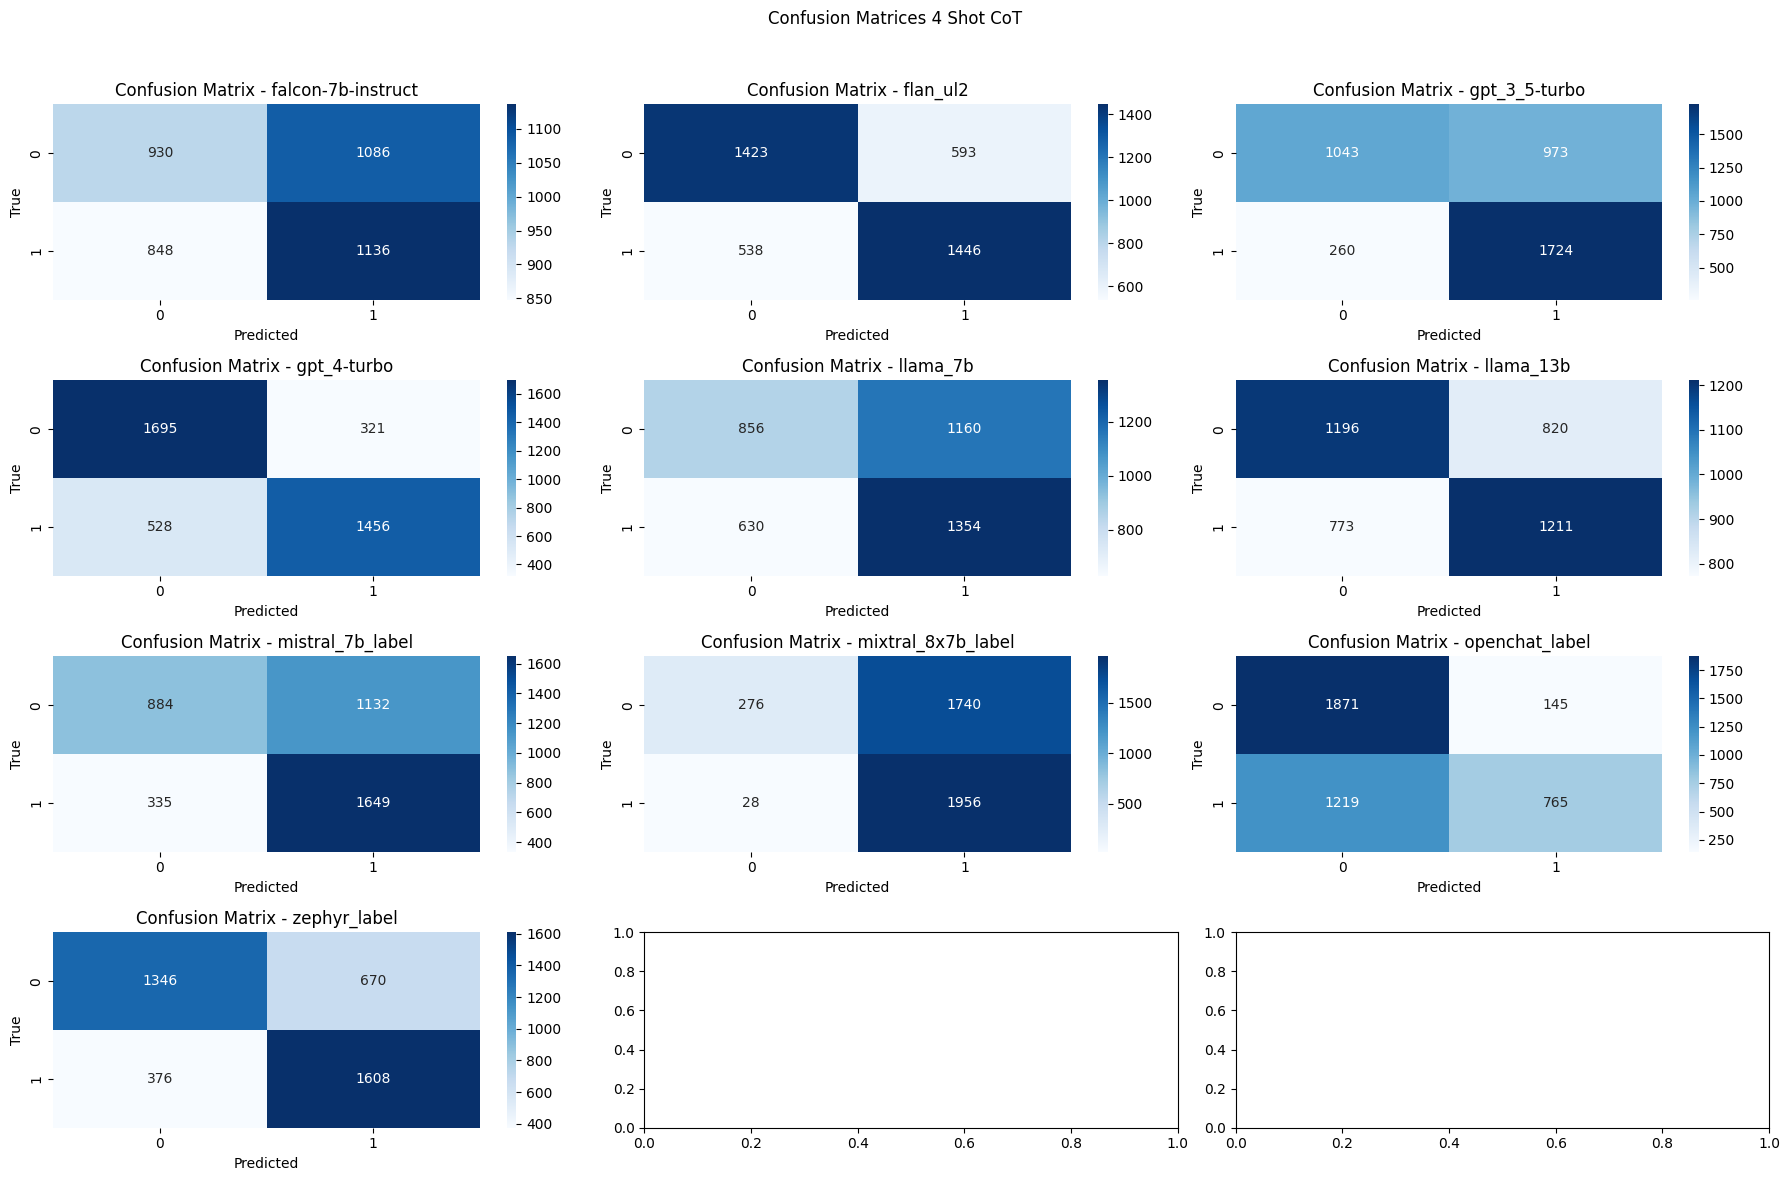

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(ax, df, true_labels_column, predicted_labels_column,
                          title=None
                          ):
    predicted_labels = df[f'{predicted_labels_column}'].astype(int)
    true_labels = df[f'{true_labels_column}'].astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)


    # Display confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True,
                yticklabels=True, ax=ax)

    title = title if title else predicted_labels_column

    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices 4 Shot CoT')


#df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
#df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
#df_openai_gpt_3_5_turbo = pd.read_csv('/homeanonymousPycharmProjects/Annomatic_Benchmark/4-shot-CoT/data/gpt-3.5-turbo.csv')
#df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4-1106-preview.csv")
#df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
#df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
#df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
#df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
#df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
#df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")


# Plot each confusion matrix
plot_confusion_matrix(axes[0, 0], df_merge_all_runs, 'label', 'falcon_7b_label', 'falcon-7b-instruct')
plot_confusion_matrix(axes[0, 1], df_merge_all_runs, 'label', 'flan_ul2_label', 'flan_ul2')
plot_confusion_matrix(axes[0, 2], df_merge_all_runs, 'label', 'gpt_3_5_label', 'gpt_3_5-turbo')
plot_confusion_matrix(axes[1, 0], df_merge_all_runs, 'label', 'gpt_4_label', 'gpt_4-turbo')
plot_confusion_matrix(axes[1, 1], df_merge_all_runs, 'label', 'llama_7b_label', 'llama_7b')
plot_confusion_matrix(axes[1, 2], df_merge_all_runs, 'label', 'llama_13b_label', 'llama_13b')
plot_confusion_matrix(axes[2, 0], df_merge_all_runs, 'label', 'mistral_7b_label', 'mistral_7b_label')
plot_confusion_matrix(axes[2, 1], df_merge_all_runs, 'label', 'mixtral_8x7b_label', 'mixtral_8x7b_label')
plot_confusion_matrix(axes[2, 2], df_merge_all_runs, 'label', 'openchat_label', 'openchat_label')
plot_confusion_matrix(axes[3, 0], df_merge_all_runs, 'label', 'zephyr_label', 'zephyr_label')




plt.tight_layout(
    rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
plt.show()

# Krippendorff Alpha in 4-shot CoT

In [53]:
from krippendorff import alpha
import numpy as np

runs = ['falcon_7b_label', 'flan_ul2_label',
       'gpt_3_5_label', 'gpt_4_label', 'llama_7b_label', 'llama_13b_label',
       'mistral_7b_label', 'mixtral_8x7b_label', 'openchat_label',
       'zephyr_label']


def compute_krippendorff_alpha(dataframe, columns, missing_data='?'):
    """
    Compute Krippendorff's alpha for inter-rater reliability.

    Parameters:
    - dataframe: pd.DataFrame, the DataFrame containing the data.
    - columns: list, the list of column names to calculate alpha for.

    Returns:
    - alpha_value: float, Krippendorff's alpha value.
    """
    # Extract the relevant columns from the DataFrame
    data_subset = dataframe[columns]
    data_subset = data_subset.replace(missing_data, np.nan)

    # Ensure that the data is in a format suitable for krippendorff
    data_list = np.array([data_subset[col].tolist() for col in columns])

    # Calculate Krippendorff's alpha
    alpha_value = alpha(reliability_data=data_list)

    return alpha_value

In [54]:
alpha_value_with_errors = compute_krippendorff_alpha(df_merge_all_runs_with_errors, runs)
alpha_value_without_errors = compute_krippendorff_alpha(df_merge_all_runs, runs)

print(f"Krippendorff's Alpha (all runs with invalid data): {alpha_value_with_errors}")
print(f"Krippendorff's Alpha (all runs without invalid data): {alpha_value_without_errors}")

Krippendorff's Alpha (all runs with invalid data): 0.2182567215607525
Krippendorff's Alpha (all runs without invalid data): 0.21741741161597739


In [55]:
import itertools

def compute_krippendorff_alpha_for_k_runs(df, runs, k=None):
    # Initialize variables to store the best combination and alpha
    if k is None:
        k = len(runs)

    best_combination = None
    best_alpha = 0  # Assuming alpha ranges from 0 to 1

    # Iterate through all possible combinations
    for combination in itertools.combinations(runs, k):

        alpha_value = compute_krippendorff_alpha(df, list(combination))

        # Print alpha for the current combination
        print(f"Combination: {combination}, Alpha: {alpha_value}")

        # Update best combination and alpha if a higher alpha is found
        if alpha_value > best_alpha:
            best_alpha = alpha_value
            best_combination = combination

    # Print the best combination and alpha
    print(f"\nBest Combination: {best_combination}, Best Alpha: {best_alpha}")
    return best_alpha, best_combination

In [56]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs, runs, 3)

Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.14698977568020466
Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_4_label'), Alpha: 0.18903505462830228
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_7b_label'), Alpha: 0.07599289535479081
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_13b_label'), Alpha: 0.09526574273022637
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mistral_7b_label'), Alpha: 0.10989288151686893
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mixtral_8x7b_label'), Alpha: -0.02943999237056727
Combination: ('falcon_7b_label', 'flan_ul2_label', 'openchat_label'), Alpha: 0.07440605249790866
Combination: ('falcon_7b_label', 'flan_ul2_label', 'zephyr_label'), Alpha: 0.18045399094173287
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'gpt_4_label'), Alpha: 0.16922269953381597
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_7b_label'), Alpha: 0.08310441682799152
Combination: ('falcon_7b_label', 

(0.5682633381904514, ('flan_ul2_label', 'gpt_4_label', 'zephyr_label'))

In [57]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs_with_errors, runs, 3)

Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.1468904213081288
Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_4_label'), Alpha: 0.18929860379400998
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_7b_label'), Alpha: 0.07582342343087756
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_13b_label'), Alpha: 0.09536711557441135
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mistral_7b_label'), Alpha: 0.11006948153340468
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mixtral_8x7b_label'), Alpha: -0.0288380984825507
Combination: ('falcon_7b_label', 'flan_ul2_label', 'openchat_label'), Alpha: 0.07403298162574001
Combination: ('falcon_7b_label', 'flan_ul2_label', 'zephyr_label'), Alpha: 0.18054322603268214
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'gpt_4_label'), Alpha: 0.16905441939046828
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_7b_label'), Alpha: 0.08320241441434928
Combination: ('falcon_7b_label', 'g

(0.5692184310334636, ('flan_ul2_label', 'gpt_4_label', 'zephyr_label'))

In [58]:
df_merge_all_runs.shape

(4000, 21)

In [59]:
df_merge_all_runs.query("gpt_4_label != mixtral_8x7b_label").shape

(1921, 21)